In [271]:
import numpy as np
import pandas as pd
import arviz as az
import numpyro
import numpyro.infer.initialization as init
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, SVI, Predictive, init_to_median
from numpyro.optim import Adam
from numpyro.infer.autoguide import AutoDiagonalNormal, Trace_ELBO
from numpyro.infer.reparam import CircularReparam
import numpyro.distributions as dist
from numpyro import handlers

from asterion.gp import GP, SquaredExponential

from corner import corner

import os

In [2]:
data_dir = 'data/prior'
track_name = 'm1.0Y0.26FeH0.0MLT2.1ov0.003556dif1'
track_dir = os.path.join(data_dir, track_name)

track = pd.read_csv(os.path.join(track_dir, f'{track_name}.csv'))
track.head()

,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,initial_fov,star_mass,...,E_0_31,E_0_32,E_0_33,E_0_34,E_0_35,E_0_36,E_0_37,E_0_38,E_0_39,E_0_40
0,profile4,152,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,1.216230e-06,0.000002,0.000006,0.000279,0.000014,0.000003,0.000002,0.000001,8.677974e-07,7.314938e-07
1,profile5,153,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,1.070235e-06,0.000002,0.000004,0.000047,0.000027,0.000004,0.000002,0.000001,8.865659e-07,7.333283e-07
2,profile6,154,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,9.770822e-07,0.000002,0.000003,0.000022,0.000059,0.000005,0.000002,0.000001,9.058076e-07,7.371980e-07
3,profile7,155,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,9.140089e-07,0.000001,0.000003,0.000014,0.000159,0.000006,0.000002,0.000001,9.237271e-07,7.414930e-07
4,profile8,156,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,8.694409e-07,0.000001,0.000002,0.000010,0.000672,0.000007,0.000002,0.000001,9.400169e-07,7.457830e-07


In [3]:
model_number = 708
profile = track.loc[track['model_number']==model_number].iloc[0]

In [4]:
n = np.arange(10, 30)
nu_index = [f'nu_0_{i}' for i in n]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

In [5]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_sca = profile['delta_nu']
print('delta_nu ~', round(delta_nu_sca, 2), 'muHz')

nu_max ~ 3246.74 muHz
delta_nu ~ 146.6 muHz


Text(0, 0.5, 'nu mod. 140.74 muHz')

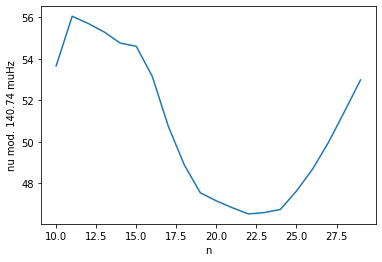

In [6]:
f = 0.96
delta_nu = f*delta_nu_sca
plt.plot(n, nu%delta_nu)
plt.xlabel('n')
plt.ylabel(f'nu mod. {delta_nu:.2f} muHz')

## Simple asymptotics

In [257]:
def linear_model(n, nu=None, nu_err=None):
    delta_nu = numpyro.sample('delta_nu', dist.Normal(141.0, 1.0))
    epsilon = numpyro.sample('epsilon', dist.Normal(1.4, 0.5))
    sigma = numpyro.sample('sigma', dist.HalfNormal(1.0))
    noise = numpyro.sample('noise', dist.HalfNormal(0.1), obs=nu_err)
    
    loc = delta_nu * (n + epsilon)
    scale = jnp.sqrt(sigma**2 + noise**2)
    
    numpyro.sample('nu', dist.Normal(loc, scale), obs=nu)

In [258]:
seed = 42
rng = random.PRNGKey(seed)

In [259]:
rng, key = random.split(rng)

prior_predictive = Predictive(linear_model, num_samples=1000)
prior_pred = prior_predictive(key, n)

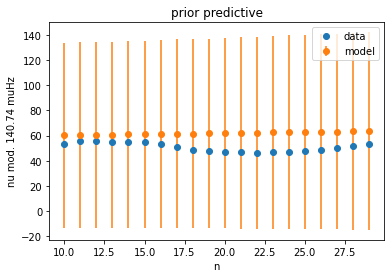

In [260]:
mean = prior_pred['nu'].mean(axis=0)
sd = prior_pred['nu'].std(axis=0)

fig, ax = plt.subplots()
ax.plot(n, nu%delta_nu, marker='o', linestyle='none', label='data')
ax.errorbar(n, mean%delta_nu, yerr=sd, marker='o', linestyle='none', label='model')
ax.set_xlabel('n')
ax.set_ylabel(f'nu mod. {delta_nu:.2f} muHz')
ax.set_title('prior predictive')
ax.legend();

In [261]:
num_warmup = 1000
num_samples = 1000
num_chains = 5

sampler = NUTS(linear_model, target_accept_prob=0.9)
mcmc = MCMC(sampler, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [262]:
rng, key = random.split(rng)

mcmc.run(key, n, nu=nu, nu_err=0.0)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [263]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  delta_nu    140.38      0.10    140.38    140.22    140.55   1154.72      1.00
   epsilon      1.41      0.02      1.41      1.39      1.44   1207.28      1.00
     sigma      2.52      0.35      2.49      1.97      3.07   1690.91      1.00

Number of divergences: 0


In [264]:
samples = mcmc.get_samples()

In [265]:
rng, key = random.split(rng)

post_predictive = Predictive(linear_model, samples)
post_pred = post_predictive(rng_key, n)

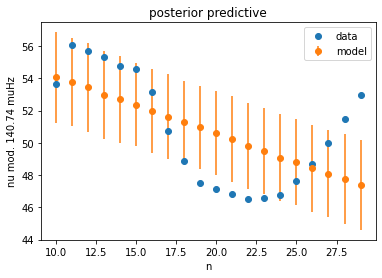

In [266]:
mean = post_pred['nu'].mean(axis=0)
sd = post_pred['nu'].std(axis=0)

fig, ax = plt.subplots()
ax.plot(n, nu%delta_nu, marker='o', linestyle='none', label='data')
ax.errorbar(n, mean%delta_nu, yerr=sd, marker='o', linestyle='none', label='model')
ax.set_xlabel('n')
ax.set_ylabel(f'nu mod. {delta_nu:.2f} muHz')
ax.set_title('posterior predictive')
ax.legend();

What if we use a GP to model the residuals

In [319]:
var = 10.0
length = 5.0

num_draws = 50
num_pred = 250
n_pred = np.linspace(n.min(), n.max(), num_pred)

rng, key = random.split(rng, 3)

kernel = SquaredExponential(var, length)
gp = GP(kernel)
dnu = gp.sample('dnu', n, sample_shape=(num_draws,), rng_key=key)

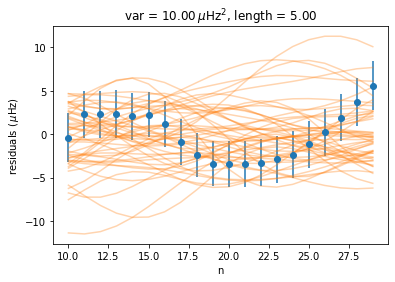

In [335]:
fig, ax = plt.subplots()

plt.errorbar(n, nu - mean, yerr=sd, color='C0', marker='o', linestyle='none')

nn = np.broadcast_to(n, dnu.shape)
ax.plot(nn.T, dnu.T, color='C1', alpha=0.33)

ax.set_xlabel('n')
ax.set_ylabel(r'residuals ($\,\mu\mathrm{Hz}$)')

ax.set_title(f'var = {var:.2f}' + r'$\,\mu\mathrm{Hz}^2$, ' + f'length = {length:.2f}');

## GP model

In [338]:
def gp_model(n, n_pred=None, nu=None, nu_err=None):
    delta_nu = numpyro.sample('delta_nu', dist.Normal(141.0, 1.0))
    epsilon = numpyro.sample('epsilon', dist.Normal(1.4, 0.5))
    noise = numpyro.sample('noise', dist.HalfNormal(0.1), obs=nu_err)
    
    mean = numpyro.deterministic('mean', delta_nu * (n + epsilon))
        
    var = 10.0
    length = 5.0
    
    kernel = SquaredExponential(var, length)
    gp = GP(kernel)
    
    dnu = None if nu is None else nu - mean
    gp.sample('dnu', n, noise=noise, obs=dnu)

    if n_pred is not None:
        mean_pred = numpyro.deterministic('mean_pred', delta_nu * (n_pred + epsilon))
        dnu_pred = gp.predict('dnu_pred', n_pred)

In [339]:
rng, key = random.split(rng)

prior_predictive = Predictive(gp_model, num_samples=1000)
prior_pred = prior_predictive(key, n, n_pred=n_pred, nu_err=0.0)

In [344]:
prior_pred['mean_pred'].shape

(1000, 250)

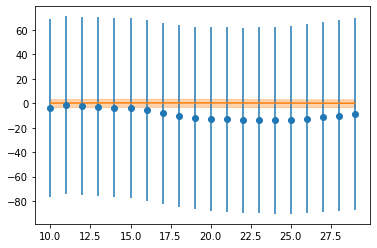

In [350]:
fig, ax = plt.subplots()

# y = nu - mean

mean = prior_pred['mean'].mean(axis=0)
sd = prior_pred['mean'].std(axis=0)

plt.errorbar(n, nu - mean, yerr=sd, marker='o', linestyle='none')

mean = prior_pred['dnu_pred'].mean(axis=0)
sd = prior_pred['dnu_pred'].std(axis=0)
plt.plot(n_pred, mean, color='C1')
plt.fill_between(n_pred, mean-sd, mean+sd, color='C1', alpha=0.33)
# prior_pred['dnu_pred']

In [351]:
init_strategy = init_to_median(num_samples=100)

sampler = NUTS(gp_model, target_accept_prob=0.9, init_strategy=init_strategy)
mcmc = MCMC(sampler, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [352]:
rng, key = random.split(rng)
mcmc.warmup(key, n, nu=nu, nu_err=0.0, collect_warmup=True)

warmup_samples = mcmc.get_samples(group_by_chain=True)

rng, key = random.split(rng)
mcmc.run(key, n, nu=nu, nu_err=0.0)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [353]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  delta_nu    143.19      0.17    143.19    142.91    143.47    885.07      1.00
   epsilon      0.58      0.03      0.58      0.53      0.62    833.10      1.01

Number of divergences: 0


In [356]:
samples = mcmc.get_samples(group_by_chain=True)

array([[<AxesSubplot:title={'center':'delta_nu'}>,
        <AxesSubplot:title={'center':'delta_nu'}>],
       [<AxesSubplot:title={'center':'epsilon'}>,
        <AxesSubplot:title={'center':'epsilon'}>],
       [<AxesSubplot:title={'center':'mean'}>,
        <AxesSubplot:title={'center':'mean'}>]], dtype=object)

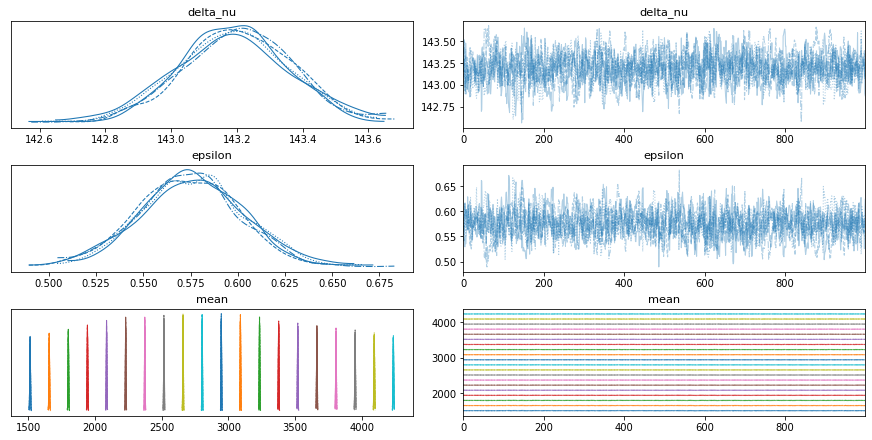

In [357]:
az.plot_trace(samples)

In [358]:
samples = mcmc.get_samples(group_by_chain=False)

In [359]:
rng, key = random.split(rng)

post_predictive = Predictive(gp_model, samples)
post_pred = post_predictive(rng_key, n, n_pred=n_pred, nu_err=0.0)

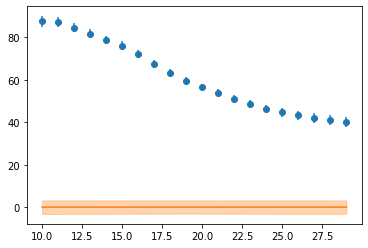

In [361]:
fig, ax = plt.subplots()

# y = nu - mean

mean = post_pred['mean'].mean(axis=0)
sd = post_pred['mean'].std(axis=0)

plt.errorbar(n, nu - mean, yerr=sd, marker='o', linestyle='none')

mean = post_pred['dnu_pred'].mean(axis=0)
sd = post_pred['dnu_pred'].std(axis=0)
plt.plot(n_pred, mean, color='C1')
plt.fill_between(n_pred, mean-sd, mean+sd, color='C1', alpha=0.33)
# prior_pred['dnu_pred']

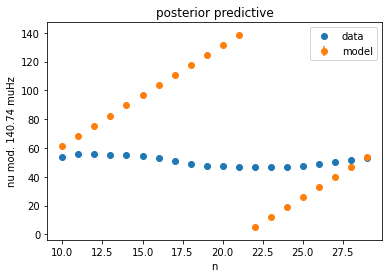

In [253]:
mean = post_pred['nu_pred'].mean(axis=0)
sd = post_pred['nu_pred'].std(axis=0)

fig, ax = plt.subplots()
ax.plot(n, nu%delta_nu, marker='o', linestyle='none', label='data')
ax.errorbar(n, mean%delta_nu, yerr=sd, marker='o', linestyle='none', label='model')
ax.set_xlabel('n')
ax.set_ylabel(f'nu mod. {delta_nu:.2f} muHz')
ax.set_title('posterior predictive')
ax.legend();

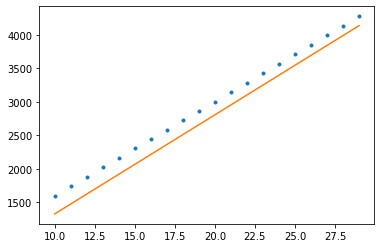

In [239]:
plt.plot(n, nu, '.')
plt.plot(n, mean)